## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp016'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 448 #224
    tile_size = 448 #224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 448, 448])

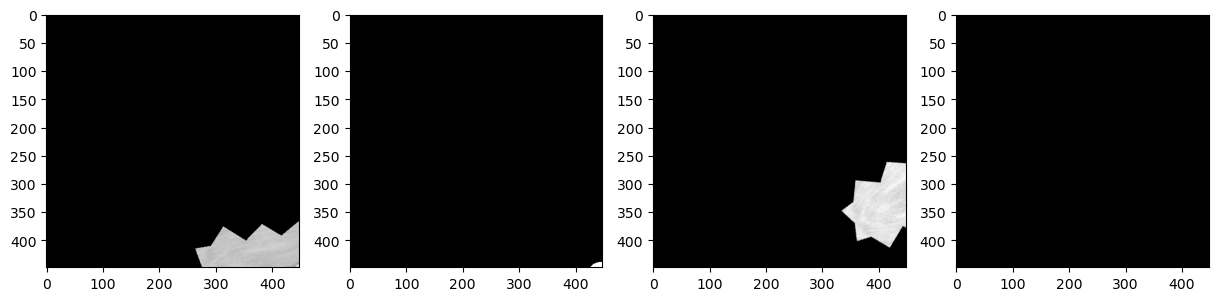

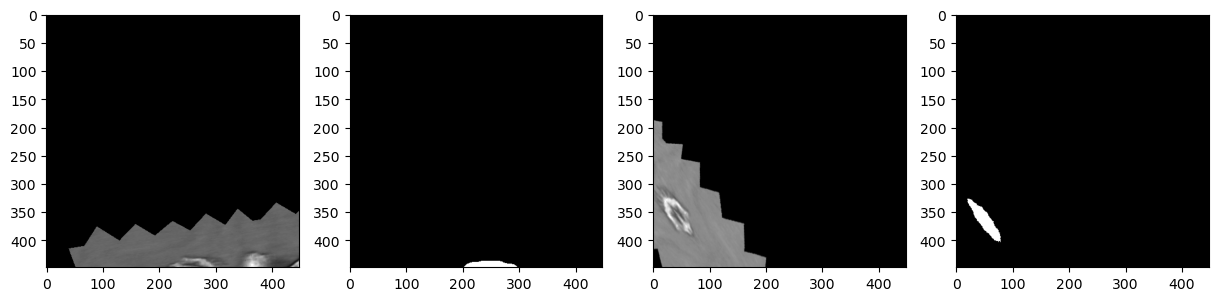

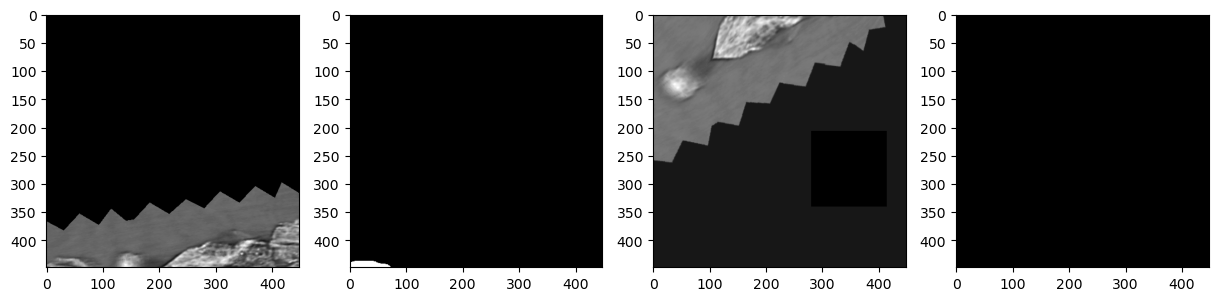

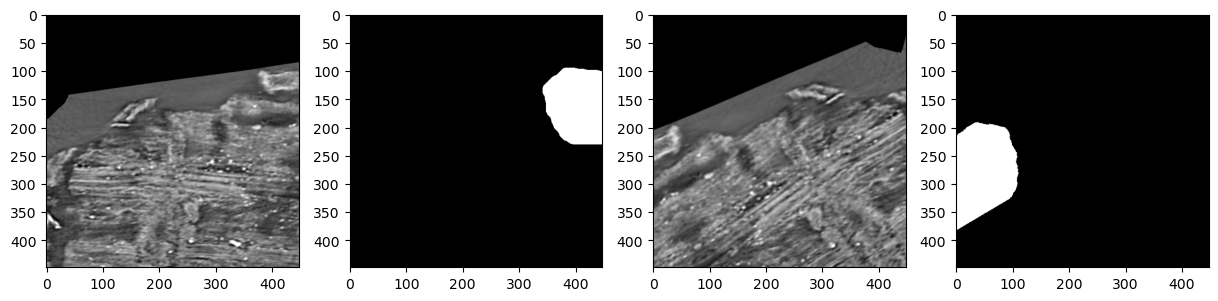

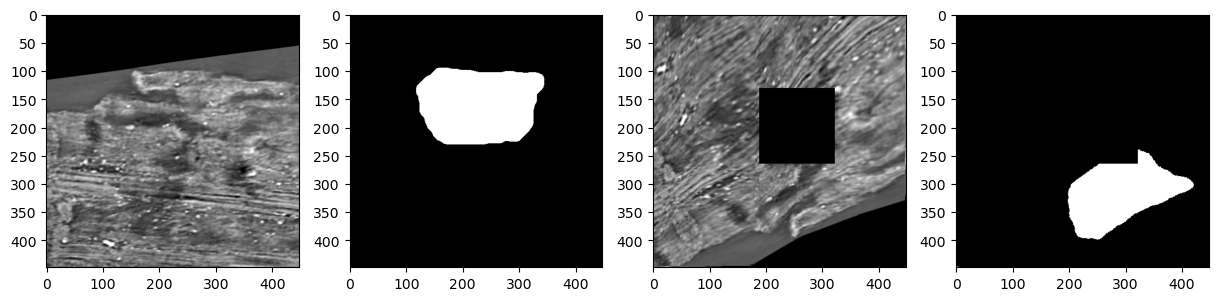

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48115

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.1356596218825398
th: 0.15, fbeta: 0.13620490623674386
th: 0.2, fbeta: 0.151242213839765
th: 0.25, fbeta: 0.1900228382118527
th: 0.3, fbeta: 0.2071514092445519
th: 0.35, fbeta: 0.2130096444768078
th: 0.4, fbeta: 0.21294849314962014
th: 0.45, fbeta: 0.20797961951106084


best_th: 0.35, fbeta: 0.2130096444768078
Epoch 1 - avg_train_loss: 0.5070  avg_val_loss: 0.4753  time: 135s
Epoch 1 - avgScore: 0.2130
Epoch 1 - Save Best Score: 0.2130 Model
Epoch 1 - Save Best Loss: 0.4753 Model


th: 0.5, fbeta: 0.1919956729659662


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.13620093028881158
th: 0.15, fbeta: 0.13704112711750974
th: 0.2, fbeta: 0.16047629724676646
th: 0.25, fbeta: 0.2126907785805062
th: 0.3, fbeta: 0.22414779067576893
th: 0.35, fbeta: 0.2272206241005294
th: 0.4, fbeta: 0.22250462109620237
th: 0.45, fbeta: 0.20126224853684274


best_th: 0.35, fbeta: 0.2272206241005294
Epoch 2 - avg_train_loss: 0.4077  avg_val_loss: 0.4207  time: 133s
Epoch 2 - avgScore: 0.2272
Epoch 2 - Save Best Score: 0.2272 Model
Epoch 2 - Save Best Loss: 0.4207 Model


th: 0.5, fbeta: 0.15353242790082602


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.1637679381136024
th: 0.15, fbeta: 0.3011548230522475
th: 0.2, fbeta: 0.335375278333724
th: 0.25, fbeta: 0.35042222973131965
th: 0.3, fbeta: 0.3501821273623691
th: 0.35, fbeta: 0.3336808777483304
th: 0.4, fbeta: 0.30114618442814806
th: 0.45, fbeta: 0.25199871560119375


best_th: 0.25, fbeta: 0.35042222973131965
Epoch 3 - avg_train_loss: 0.2989  avg_val_loss: 0.3340  time: 132s
Epoch 3 - avgScore: 0.3504
Epoch 3 - Save Best Score: 0.3504 Model
Epoch 3 - Save Best Loss: 0.3340 Model


th: 0.5, fbeta: 0.1800075609961318


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2747987322523957
th: 0.15, fbeta: 0.21338002451227772
th: 0.2, fbeta: 0.15560348411493502
th: 0.25, fbeta: 0.11127886172130984
th: 0.3, fbeta: 0.07882736858672565
th: 0.35, fbeta: 0.05233557941407354
th: 0.4, fbeta: 0.03259917183112537
th: 0.45, fbeta: 0.01987532789058294


best_th: 0.1, fbeta: 0.2747987322523957
Epoch 4 - avg_train_loss: 0.2090  avg_val_loss: 0.3764  time: 132s
Epoch 4 - avgScore: 0.2748


th: 0.5, fbeta: 0.012084765188676697


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2559987201358407
th: 0.15, fbeta: 0.1953687935811364
th: 0.2, fbeta: 0.1564070165444573
th: 0.25, fbeta: 0.12574616142698594
th: 0.3, fbeta: 0.1030872764399946
th: 0.35, fbeta: 0.08592238725896685
th: 0.4, fbeta: 0.07167106192342201
th: 0.45, fbeta: 0.060106008105519595


best_th: 0.1, fbeta: 0.2559987201358407
Epoch 5 - avg_train_loss: 0.1769  avg_val_loss: 0.4199  time: 131s
Epoch 5 - avgScore: 0.2560


th: 0.5, fbeta: 0.050101121600109676


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.27098315958146474
th: 0.15, fbeta: 0.21651783506493763
th: 0.2, fbeta: 0.16934250710552867
th: 0.25, fbeta: 0.13291228439137626
th: 0.3, fbeta: 0.10448584512200361
th: 0.35, fbeta: 0.08369116550486622
th: 0.4, fbeta: 0.06722349026728791
th: 0.45, fbeta: 0.05348369683971392


best_th: 0.1, fbeta: 0.27098315958146474
Epoch 6 - avg_train_loss: 0.1604  avg_val_loss: 0.4393  time: 131s
Epoch 6 - avgScore: 0.2710


th: 0.5, fbeta: 0.042009543901930325


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2210173112023361
th: 0.15, fbeta: 0.17148171444645655
th: 0.2, fbeta: 0.1336450134640532
th: 0.25, fbeta: 0.10675671073260451
th: 0.3, fbeta: 0.08564501392044864
th: 0.35, fbeta: 0.06799086176876498
th: 0.4, fbeta: 0.05416024497705968
th: 0.45, fbeta: 0.04308834767158253


best_th: 0.1, fbeta: 0.2210173112023361
Epoch 7 - avg_train_loss: 0.1368  avg_val_loss: 0.4586  time: 131s
Epoch 7 - avgScore: 0.2210


th: 0.5, fbeta: 0.03413187977916682


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23374059180920828
th: 0.15, fbeta: 0.18853666173844233
th: 0.2, fbeta: 0.14848819149409054
th: 0.25, fbeta: 0.11375835002849927
th: 0.3, fbeta: 0.08723271015163236
th: 0.35, fbeta: 0.06788876812339793
th: 0.4, fbeta: 0.05240177448444467
th: 0.45, fbeta: 0.04023803315902766


best_th: 0.1, fbeta: 0.23374059180920828
Epoch 8 - avg_train_loss: 0.1263  avg_val_loss: 0.4886  time: 131s
Epoch 8 - avgScore: 0.2337


th: 0.5, fbeta: 0.03038894158678205


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3453662906649704
th: 0.15, fbeta: 0.3268395564647081
th: 0.2, fbeta: 0.30303417718505243
th: 0.25, fbeta: 0.2756697675868942
th: 0.3, fbeta: 0.2498815919619882
th: 0.35, fbeta: 0.22465303281490653
th: 0.4, fbeta: 0.19874019548700783
th: 0.45, fbeta: 0.17270459769919236


best_th: 0.1, fbeta: 0.3453662906649704
Epoch 9 - avg_train_loss: 0.1163  avg_val_loss: 0.4718  time: 131s
Epoch 9 - avgScore: 0.3454


th: 0.5, fbeta: 0.1480224318579433


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2924803399898989
th: 0.15, fbeta: 0.26014240229461855
th: 0.2, fbeta: 0.22810551717337516
th: 0.25, fbeta: 0.1954688386479815
th: 0.3, fbeta: 0.16528936857335363
th: 0.35, fbeta: 0.1375357968554447
th: 0.4, fbeta: 0.11402507788451752
th: 0.45, fbeta: 0.095165642284534


best_th: 0.1, fbeta: 0.2924803399898989
Epoch 10 - avg_train_loss: 0.1054  avg_val_loss: 0.5114  time: 131s
Epoch 10 - avgScore: 0.2925


th: 0.5, fbeta: 0.07836300490564706


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.12721444154496142
th: 0.15, fbeta: 0.0884975258140962
th: 0.2, fbeta: 0.0637194461000977
th: 0.25, fbeta: 0.046373143208312116
th: 0.3, fbeta: 0.03422936865962658
th: 0.35, fbeta: 0.02446122198798587
th: 0.4, fbeta: 0.017603823165314465
th: 0.45, fbeta: 0.013171973160507076


best_th: 0.1, fbeta: 0.12721444154496142
Epoch 11 - avg_train_loss: 0.0991  avg_val_loss: 0.5763  time: 131s
Epoch 11 - avgScore: 0.1272


th: 0.5, fbeta: 0.009649689133262768


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2807579367249042
th: 0.15, fbeta: 0.25225942274469804
th: 0.2, fbeta: 0.22407560453424377
th: 0.25, fbeta: 0.19484370302362494
th: 0.3, fbeta: 0.16842582420221977
th: 0.35, fbeta: 0.14358444697716521
th: 0.4, fbeta: 0.12024243702002228
th: 0.45, fbeta: 0.10125319585925079


best_th: 0.1, fbeta: 0.2807579367249042
Epoch 12 - avg_train_loss: 0.0906  avg_val_loss: 0.5416  time: 132s
Epoch 12 - avgScore: 0.2808


th: 0.5, fbeta: 0.08455072250434459


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3035836893074342
th: 0.15, fbeta: 0.272398287699635
th: 0.2, fbeta: 0.2465210694815188
th: 0.25, fbeta: 0.2222610617393865
th: 0.3, fbeta: 0.1975094784032574
th: 0.35, fbeta: 0.1739627786722724
th: 0.4, fbeta: 0.1544929465096521
th: 0.45, fbeta: 0.13730121760914607


best_th: 0.1, fbeta: 0.3035836893074342
Epoch 13 - avg_train_loss: 0.0853  avg_val_loss: 0.5445  time: 131s
Epoch 13 - avgScore: 0.3036


th: 0.5, fbeta: 0.1190452390352089


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3231209542591202
th: 0.15, fbeta: 0.30027311109201155
th: 0.2, fbeta: 0.2764905787446558
th: 0.25, fbeta: 0.25253874192740106
th: 0.3, fbeta: 0.22836139658621493
th: 0.35, fbeta: 0.20453294353914525
th: 0.4, fbeta: 0.18229690837122642
th: 0.45, fbeta: 0.1620549155056253


best_th: 0.1, fbeta: 0.3231209542591202
Epoch 14 - avg_train_loss: 0.0795  avg_val_loss: 0.5452  time: 131s
Epoch 14 - avgScore: 0.3231


th: 0.5, fbeta: 0.14213298632431406


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2279899824902105
th: 0.15, fbeta: 0.1882091392103896
th: 0.2, fbeta: 0.15996847682180917
th: 0.25, fbeta: 0.13754193663811576
th: 0.3, fbeta: 0.11791599744391261
th: 0.35, fbeta: 0.09975876369100123
th: 0.4, fbeta: 0.08509458416832318
th: 0.45, fbeta: 0.07233875947644197


best_th: 0.1, fbeta: 0.2279899824902105
Epoch 15 - avg_train_loss: 0.0749  avg_val_loss: 0.5649  time: 132s
Epoch 15 - avgScore: 0.2280


th: 0.5, fbeta: 0.060798097306154424


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30600872450262795
th: 0.15, fbeta: 0.2770236644683641
th: 0.2, fbeta: 0.24989840919900771
th: 0.25, fbeta: 0.22681466554276888
th: 0.3, fbeta: 0.20583763609581407
th: 0.35, fbeta: 0.18436358152467713
th: 0.4, fbeta: 0.16365326964744925
th: 0.45, fbeta: 0.1440565617091055


best_th: 0.1, fbeta: 0.30600872450262795
Epoch 16 - avg_train_loss: 0.0707  avg_val_loss: 0.5740  time: 131s
Epoch 16 - avgScore: 0.3060


th: 0.5, fbeta: 0.12739748579228655


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.17803012684445677
th: 0.15, fbeta: 0.1394016005063949
th: 0.2, fbeta: 0.10867010789300187
th: 0.25, fbeta: 0.0864086495464585
th: 0.3, fbeta: 0.07000939457989228
th: 0.35, fbeta: 0.056424805036714334
th: 0.4, fbeta: 0.04597073993589658
th: 0.45, fbeta: 0.03744792235354508


best_th: 0.1, fbeta: 0.17803012684445677
Epoch 17 - avg_train_loss: 0.0663  avg_val_loss: 0.6093  time: 131s
Epoch 17 - avgScore: 0.1780


th: 0.5, fbeta: 0.030688530660796694


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.180154884154808
th: 0.15, fbeta: 0.14925882195073467
th: 0.2, fbeta: 0.12549311722830692
th: 0.25, fbeta: 0.10581996901129281
th: 0.3, fbeta: 0.09029805397813973
th: 0.35, fbeta: 0.07631896959444227
th: 0.4, fbeta: 0.0643104151137683
th: 0.45, fbeta: 0.05382773108295947


best_th: 0.1, fbeta: 0.180154884154808
Epoch 18 - avg_train_loss: 0.0629  avg_val_loss: 0.6102  time: 131s
Epoch 18 - avgScore: 0.1802


th: 0.5, fbeta: 0.04426974577293854


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2090479360269948
th: 0.15, fbeta: 0.17511661374940818
th: 0.2, fbeta: 0.14681826812561546
th: 0.25, fbeta: 0.12498484745722102
th: 0.3, fbeta: 0.10778619955411094
th: 0.35, fbeta: 0.09216697318566498
th: 0.4, fbeta: 0.07684338711250585
th: 0.45, fbeta: 0.06352778904854266


best_th: 0.1, fbeta: 0.2090479360269948
Epoch 19 - avg_train_loss: 0.0601  avg_val_loss: 0.5927  time: 131s
Epoch 19 - avgScore: 0.2090


th: 0.5, fbeta: 0.051075414886841294


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24263949720495667
th: 0.15, fbeta: 0.2120338737389288
th: 0.2, fbeta: 0.18564938616460314
th: 0.25, fbeta: 0.16560515644340934
th: 0.3, fbeta: 0.1478342654816354
th: 0.35, fbeta: 0.13048997390008518
th: 0.4, fbeta: 0.11342219232992
th: 0.45, fbeta: 0.0976059789393423


best_th: 0.1, fbeta: 0.24263949720495667
Epoch 20 - avg_train_loss: 0.0555  avg_val_loss: 0.6102  time: 132s
Epoch 20 - avgScore: 0.2426


th: 0.5, fbeta: 0.0819259324880626


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.15914930156236565
th: 0.15, fbeta: 0.13124144617291622
th: 0.2, fbeta: 0.11083023994563679
th: 0.25, fbeta: 0.09454521167280293
th: 0.3, fbeta: 0.07980652591944246
th: 0.35, fbeta: 0.06652737987079788
th: 0.4, fbeta: 0.055383766855454014
th: 0.45, fbeta: 0.04548306587255995


best_th: 0.1, fbeta: 0.15914930156236565
Epoch 21 - avg_train_loss: 0.0553  avg_val_loss: 0.6395  time: 132s
Epoch 21 - avgScore: 0.1591


th: 0.5, fbeta: 0.036464685198608474


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1957076742548535
th: 0.15, fbeta: 0.16722791496686543
th: 0.2, fbeta: 0.14527573049541576
th: 0.25, fbeta: 0.12680717772654568
th: 0.3, fbeta: 0.10997078039575799
th: 0.35, fbeta: 0.09518293401431402
th: 0.4, fbeta: 0.08218280320300271
th: 0.45, fbeta: 0.07095488877719038


best_th: 0.1, fbeta: 0.1957076742548535
Epoch 22 - avg_train_loss: 0.0525  avg_val_loss: 0.6392  time: 132s
Epoch 22 - avgScore: 0.1957


th: 0.5, fbeta: 0.06054907975408602


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.25646660891240747
th: 0.15, fbeta: 0.23043565857342183
th: 0.2, fbeta: 0.20674978647854114
th: 0.25, fbeta: 0.18541112407586643
th: 0.3, fbeta: 0.16569096305552364
th: 0.35, fbeta: 0.14766693733698263
th: 0.4, fbeta: 0.13212221451569525
th: 0.45, fbeta: 0.1177905609602733


best_th: 0.1, fbeta: 0.25646660891240747
Epoch 23 - avg_train_loss: 0.0502  avg_val_loss: 0.6261  time: 131s
Epoch 23 - avgScore: 0.2565


th: 0.5, fbeta: 0.10268273677461369


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1555011526342956
th: 0.15, fbeta: 0.1263444384624903
th: 0.2, fbeta: 0.104364828051347
th: 0.25, fbeta: 0.08737644783054048
th: 0.3, fbeta: 0.07366238220336932
th: 0.35, fbeta: 0.06139883650191085
th: 0.4, fbeta: 0.051144188871238914
th: 0.45, fbeta: 0.04216234860187442


best_th: 0.1, fbeta: 0.1555011526342956
Epoch 24 - avg_train_loss: 0.0478  avg_val_loss: 0.6578  time: 131s
Epoch 24 - avgScore: 0.1555


th: 0.5, fbeta: 0.03133255007542496


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2105604187760989
th: 0.15, fbeta: 0.1772633903064679
th: 0.2, fbeta: 0.15126381673723965
th: 0.25, fbeta: 0.13071660148223022
th: 0.3, fbeta: 0.1146258603294168
th: 0.35, fbeta: 0.10022806589200114
th: 0.4, fbeta: 0.0871479137849509
th: 0.45, fbeta: 0.07580091810454143


best_th: 0.1, fbeta: 0.2105604187760989
Epoch 25 - avg_train_loss: 0.0466  avg_val_loss: 0.6485  time: 131s
Epoch 25 - avgScore: 0.2106


th: 0.5, fbeta: 0.06488959068516409


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.16215856569079182
th: 0.15, fbeta: 0.13254136986007703
th: 0.2, fbeta: 0.11344012177946912
th: 0.25, fbeta: 0.09706404170378506
th: 0.3, fbeta: 0.08361926676481658
th: 0.35, fbeta: 0.07203153034534505
th: 0.4, fbeta: 0.061582000984384384
th: 0.45, fbeta: 0.05237119558041988


best_th: 0.1, fbeta: 0.16215856569079182
Epoch 26 - avg_train_loss: 0.0458  avg_val_loss: 0.6685  time: 131s
Epoch 26 - avgScore: 0.1622


th: 0.5, fbeta: 0.0426557806532339


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1989380993507958
th: 0.15, fbeta: 0.16957522532981933
th: 0.2, fbeta: 0.14450499801832667
th: 0.25, fbeta: 0.12452209190540355
th: 0.3, fbeta: 0.10856712616889636
th: 0.35, fbeta: 0.09608005177765537
th: 0.4, fbeta: 0.08456969638408912
th: 0.45, fbeta: 0.07402508314809485


best_th: 0.1, fbeta: 0.1989380993507958
Epoch 27 - avg_train_loss: 0.0438  avg_val_loss: 0.6626  time: 131s
Epoch 27 - avgScore: 0.1989


th: 0.5, fbeta: 0.06328938640009092


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.153099307687756
th: 0.15, fbeta: 0.126122215359349
th: 0.2, fbeta: 0.10619426347337634
th: 0.25, fbeta: 0.09059390358898609
th: 0.3, fbeta: 0.07786213444785277
th: 0.35, fbeta: 0.06734087819543295
th: 0.4, fbeta: 0.05831769503000926
th: 0.45, fbeta: 0.0491987990077028


best_th: 0.1, fbeta: 0.153099307687756
Epoch 28 - avg_train_loss: 0.0435  avg_val_loss: 0.6885  time: 131s
Epoch 28 - avgScore: 0.1531


th: 0.5, fbeta: 0.039406646435514156


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2034217010428314
th: 0.15, fbeta: 0.17511903427741313
th: 0.2, fbeta: 0.15315169957377295
th: 0.25, fbeta: 0.13497199587912662
th: 0.3, fbeta: 0.11940982424382036
th: 0.35, fbeta: 0.10565071462396573
th: 0.4, fbeta: 0.09399636868143292
th: 0.45, fbeta: 0.08256612345323494


best_th: 0.1, fbeta: 0.2034217010428314
Epoch 29 - avg_train_loss: 0.0441  avg_val_loss: 0.6690  time: 132s
Epoch 29 - avgScore: 0.2034


th: 0.5, fbeta: 0.07073196011734345


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.19703372246375264
th: 0.15, fbeta: 0.16664097701454295
th: 0.2, fbeta: 0.14388444722697588
th: 0.25, fbeta: 0.12478646122614345
th: 0.3, fbeta: 0.10960369495692814
th: 0.35, fbeta: 0.09673740146935061
th: 0.4, fbeta: 0.08507705055930335
th: 0.45, fbeta: 0.07426435937346738


best_th: 0.1, fbeta: 0.19703372246375264
Epoch 30 - avg_train_loss: 0.0437  avg_val_loss: 0.6708  time: 131s
Epoch 30 - avgScore: 0.1970


th: 0.5, fbeta: 0.06405114531588517


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.1637679381136024
th: 0.15, fbeta: 0.3011548230522475
th: 0.2, fbeta: 0.335375278333724
th: 0.25, fbeta: 0.35042222973131965
th: 0.3, fbeta: 0.3501821273623691
th: 0.35, fbeta: 0.3336808777483304
th: 0.4, fbeta: 0.30114618442814806
th: 0.45, fbeta: 0.25199871560119375


best_th: 0.25, fbeta: 0.35042222973131965


th: 0.5, fbeta: 0.1800075609961318


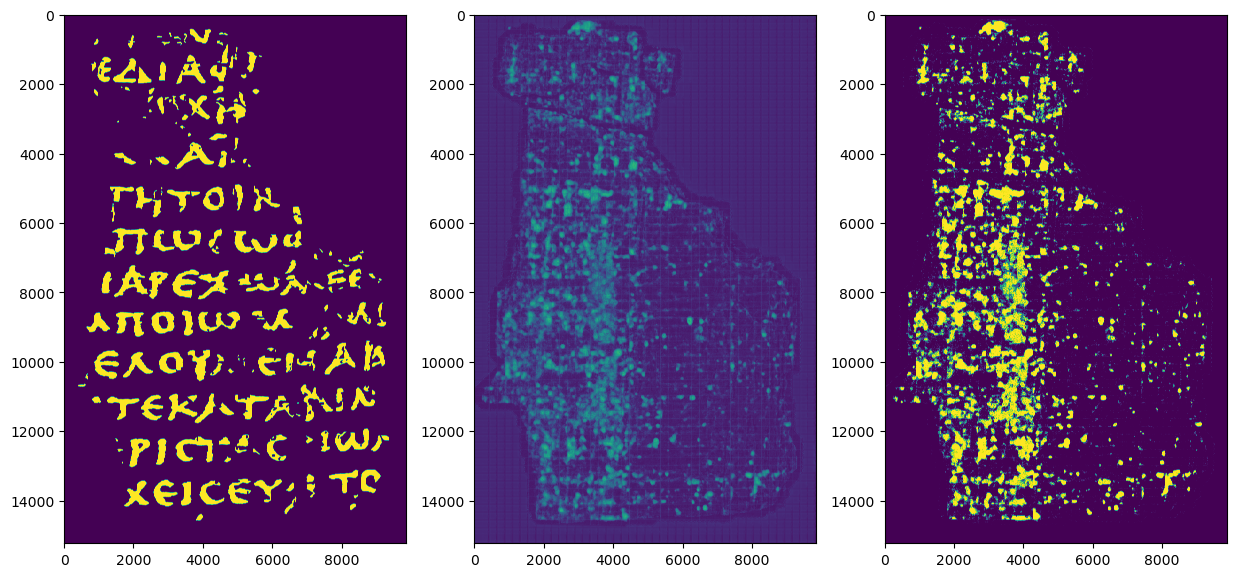

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.5735630e+06, 4.5237475e+07, 6.4312336e+07, 1.2679448e+07,
        7.2970070e+06, 4.9401000e+06, 3.8526200e+06, 3.1783700e+06,
        2.4462700e+06, 1.8672640e+06, 1.3907730e+06, 8.5044100e+05,
        3.9290000e+05, 8.5993000e+04, 1.5725000e+04, 4.4670000e+03,
        1.3460000e+03, 3.9600000e+02, 8.5000000e+01, 1.3000000e+01]),
 array([3.39899532e-04, 4.70767000e-02, 9.38135005e-02, 1.40550301e-01,
        1.87287101e-01, 2.34023902e-01, 2.80760702e-01, 3.27497503e-01,
        3.74234303e-01, 4.20971104e-01, 4.67707904e-01, 5.14444705e-01,
        5.61181505e-01, 6.07918306e-01, 6.54655106e-01, 7.01391907e-01,
        7.48128707e-01, 7.94865507e-01, 8.41602308e-01, 8.88339108e-01,
        9.35075909e-01]),
 <BarContainer object of 20 artists>)

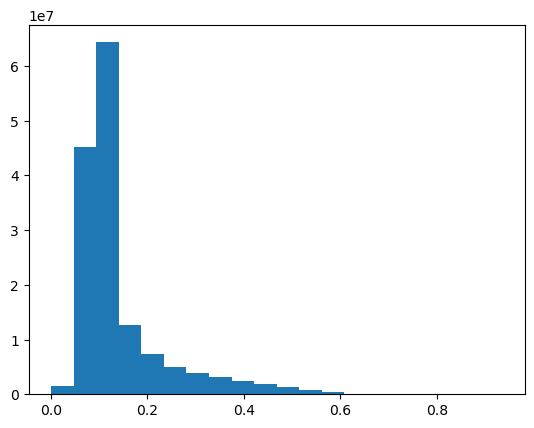

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000